In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
from scipy.fft import fft, fftfreq

## Main Code

In [5]:
#spatial variables
dt = 0.00005 
dx = dt * 1000

simulation_time=1 #sec
coeff_drag = 1.2

#################################################################################################

#getting real life guitar string data
#source = https://www.daddario.com/products/guitar/acoustic-guitar/phosphor-bronze/ej26-phosphor-bronze-acoustic-guitar-strings-custom-light-11-52/ 

# _string = [tension, diameter]
e_string = [87.319, 0.000279] #N, m
B_string = [91.144,	0.000381]
G_string = [113.252, 0.000558]
D_string = [133.135, 0.000812]
A_string = [128.687, 0.001066]
E_string = [107.780, 0.001320]
strings = [e_string, B_string, G_string, D_string, A_string, E_string]
#function to get mass of the string for certain length
def StringMass(string_data, length):
    density_of_string = 8860 #kg/m^3 density of phospher bronze

    return density_of_string * np.pi*(string_data[1]/2)**2 * length

#function to get the stifness parameter for a certain length
def epsilon_func(L, string):
    E = 110e9
    radius = string[1]/2
    return np.pi * E * radius**4 / (4*string[0]*L**2)

#################################################################################################

#inital pluck (this is our inital condition)
def initial_pluck(amplitude, position, xrange ):
    #finding the first half and second half of the x range based on the position
    #FHindex = np.where(xrange == position)[0][0]
    for i in range(len(xrange)):
            
        if abs(xrange[i] - position) <= 10e-3:
            FHindex = i
    #finding line for the first half
    FHslope = amplitude/(xrange[FHindex] - xrange[0])
    FH = FHslope * xrange[0:FHindex]

    #finding line for the second half
    SHslope = -amplitude/(xrange[-1] - xrange[FHindex])
    SHyint = -SHslope*xrange[-1]
    SH = SHslope * xrange[FHindex:len(xrange)] + SHyint

    #stitch arrays
    pluck = np.concatenate((FH,SH), axis=None)
    
    return pluck

#################################################################################################

#simulating guitar string/ wave equation
def Guitar(tmax, dt, xmax, dx, pluck_pos, amplitude, string, b):

    #calculating the speed of the wave (c)
    linear_density = np.pi * string[1]**2 * 8860/4
    speed_of_wave = np.sqrt(string[0]/(linear_density))

    #calculating eps
    epsilon = epsilon_func(xmax, string)

    xrange = np.arange(0, xmax+dx, dx)

    #number of points in the spatial and temporal dimension
    Nx = int(math.ceil((xmax)/dx)) + 1
    Nt = int(math.ceil((tmax)/dt)) + 2

    y = np.zeros((Nx,Nt))

    #set up inital conditions
    initial = initial_pluck(amplitude, pluck_pos, xrange)
    y[:,0] = initial
    y[:,1] = initial

    #coeffcients
    D = (speed_of_wave**2 * epsilon * xmax**2 * dt**2) / (dx**4)
    r = (dt**2 * speed_of_wave**2)/(dx**2)
    B = 2*dt*b
    
    #running simulation
    for n in range(1,Nt-1):
        for i in range(1, Nx-2):
            y[i, n+1] = r * (y[i+1,n] + y[i-1,n] - 2* y[i,n]) - D * (y[i+2,n] - 4*y[i+1,n] + 6*y[i,n] - 4*y[i-1,n] + y[i-2,n]) - B * (y[i,n] - y[i,n-1]) - y[i,n-1] + 2 * y[i,n]
    return xrange, y, Nt

Inital Pluck Graph

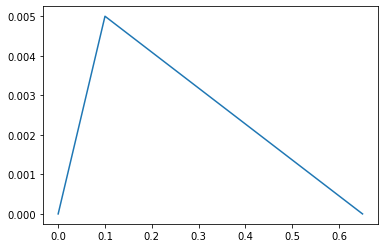

In [8]:
pluck_pos = 0.1
pluck_amp = 0.005
open_fret = 0.6096
xrange, y, Nt = Guitar(simulation_time, dt, open_fret, dx, pluck_pos, pluck_amp, e_string, coeff_drag)
plt.xlabel('Distance along the string (m)')
plt.ylabel('Vertical Displacement(m)')
plt.plot(xrange, y[:,0])

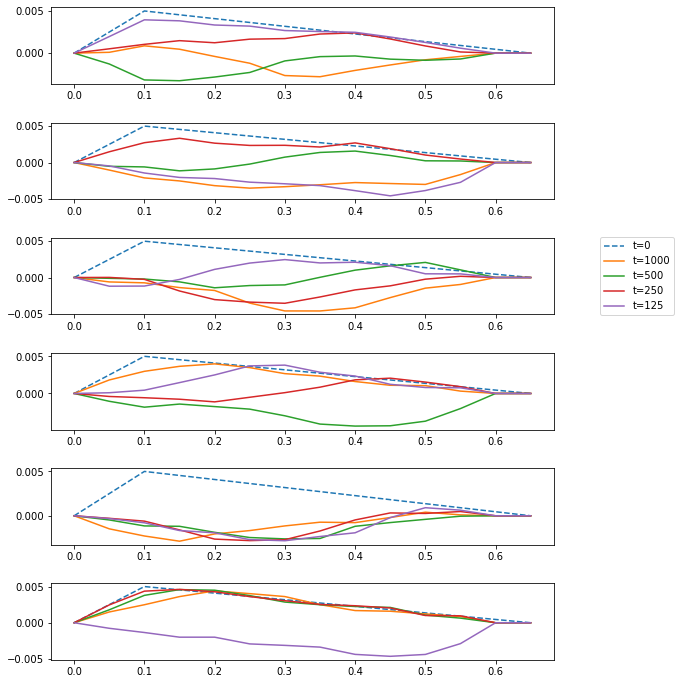

In [9]:
strings = [e_string, B_string, G_string, D_string, A_string, E_string]
plt.figure(figsize=(9, 12))
for i, string in enumerate(strings):
    xrange, y, Nt = Guitar(simulation_time, dt, 0.6096, dx, 0.1, 0.005, string, 1.2)
    plt.subplot(6, 1, i+1)  # Adjust index for subplot
    plt.plot(xrange, y[:, 0], '--', label=f"t=0")
    plt.plot(xrange, y[:, 1000], label=f"t=1000")
    plt.plot(xrange, y[:, 500], label=f"t=500")
    plt.plot(xrange, y[:, 250], label=f"t=250")
    plt.plot(xrange, y[:, 125], label=f"t=125")

plt.legend(loc='right', bbox_to_anchor=(1.25, 5))
plt.subplots_adjust(hspace=0.5)

plt.show()
